# A Simple Classical Estimator

_This notebook explores the creation and use of a classical estimator in **PyTorch** to compare against **PennyLane**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** 1 October 2024<br>
**Updates:** 1 October 2024<br>
**Aims:** To develop a simple classical estimator in PennyLane and compare it with a PyTorch classical version.<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

## Load previously prepared data set

Data set (requires: pip install sklearn):
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes" target="_blank">Diabetes</a>:
Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.  
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only (not needed)*
- *Deal with missing values (not needed)*
- *Analyse the target*
- *Standardise both predictors and target*
- *Reduce dimensionality using PCA*


### Files location

In [4]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'diabetes'
PLOTS_PATH = 'plots'

### Data set in its original form

In [5]:
from sklearn import datasets
bunch = datasets.load_diabetes(return_X_y=False, as_frame=True, scaled=False)
print(bunch.DESCR)
X_y = bunch.frame

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [6]:
X_y.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


### Load data from the store

In [7]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca = pd.read_pickle(x_file_path)
y = pd.read_pickle(y_file_path)
print(f'\nRead previously prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"\n')


Read previously prepared data set:   "diabetes" in store "rsrc"



In [8]:
### Sample of saved X predictors
nnp.round(X_pca[0:5], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
0,0.554,-0.073,0.110,-0.258,0.111,-0.149,0.070,0.128
1,-0.609,-0.280,0.133,0.195,-0.002,-0.184,-0.057,-0.002
2,0.542,-0.108,0.261,-0.140,0.285,-0.155,0.108,0.125
3,-0.452,0.107,-0.483,0.014,-0.027,0.051,-0.086,-0.017
4,-0.469,0.047,0.060,0.076,0.009,-0.151,-0.160,-0.126


In [9]:
### Sample of saved y target
y[0:5]

,target
0,0.392523
1,0.155763
2,0.361371
3,0.563863
4,0.342679


## Create a simple classical model

We will first identify what devices and gradient support we have, then prepare data for model training and testing, create a classical model, and finally train it and test it.

In [10]:
### Torch

from torch import nn
from torch.autograd import Variable
import torch

### Utilities

In [11]:
### Performance measures
from torcheval.metrics.functional import r2_score as torch_r2

def square_loss(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

def r2_score(y_true, y_pred):
    r2 = torch_r2(y_true, y_pred)
    return r2
    
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [12]:
### Find what devices are available

# Type to be used with tensors
dtype = torch.float64
torch.set_default_dtype(dtype)

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe optimum device: {torch_device}')

# Force CPU
torch_device = "cpu"
print(f'Device to be used:  {torch_device}\n')


The optimum device: cpu
Device to be used:  cpu



### Configuration constants

In [13]:
### Data params
data_frac = 1.0 # so that we would not need to wait 
n_data = 5
x_angle_margin = 0
x_angle_min = 0+x_angle_margin
x_angle_max = 1-x_angle_margin

### Training params
epochs = 1000
prompt_fract = 0.05
acc_prec = 0.5
log_interv = 1
seed = 2024

### Prepare data for the classifier

In [14]:
### Check ranges
print(f'Min X={X_pca.to_numpy().min().round(3)}, Max X={X_pca.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=-0.827, Max X=0.998, Min y=0.0, Max y=1.0


In [15]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
X_scaled = pd.DataFrame(angle_scaler.fit_transform(X_pca), columns=X_pca.columns)

In [16]:
### Take a smaller sample of data

X_y_sample = pd.concat([X_scaled, y], axis=1).sample(frac=data_frac)

### Separate X and y
y = X_y_sample['target'].to_frame()
X = X_y_sample.drop('target', axis=1)

# Recheck the X ranges
print(f'Min X={X.to_numpy().min().round(3)}, Max X={X.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=0.0, Max X=1.0, Min y=0.0, Max y=1.0


In [17]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
                                                    test_size=0.33, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(296, 5), X_test=(146, 5), y_train=(296, 1), y_test=(146, 1)


In [18]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

In [19]:
### Sample training predictors
print(X_train_tens[0:5])

tensor([[0.7826, 0.2966, 0.5682, 0.5897, 0.7483],
        [0.8627, 0.4958, 0.4517, 0.4767, 0.6054],
        [0.8955, 0.5210, 0.6284, 0.6493, 1.0000],
        [0.8062, 0.3794, 0.5032, 0.5364, 0.5075],
        [0.9063, 0.5782, 0.5151, 0.4502, 0.4541]])


In [20]:
### Sample training labels
y_train_tens[0:5]

tensor([[0.4206],
        [0.6075],
        [0.4455],
        [0.4984],
        [0.8474]])

### Model training functions

In [21]:
### Classic estimator
class Classic_Diabetes(nn.Module):

    def __init__(self, in_shape, out_shape):
        super(Classic_Diabetes, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_shape, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(8, out_shape)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
### Test if the model works as a function
test = Classic_Diabetes(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)
test(X_train_tens[0:5])

tensor([[0.2809],
        [0.2413],
        [0.5407],
        [0.2739],
        [0.2046]], grad_fn=<AddmmBackward0>)

In [23]:
### Trains the classical AE model
def train_classical(model, X, y, cost_fun, score_fun, optimizer, epochs, log_interv=100, prompt_fract=0.1):
    cost_hist = []
    r2_hist = []
    min_epoch = 0
    min_cost = 1000
    max_r2 = -1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        r2 = score_fun(output, y)
        cost.backward()
        optimizer.step()

        curr_loss = cost.item()
        curr_r2 = r2
        if curr_loss < min_cost: 
            min_cost = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_r2 > max_r2:
            max_r2 = curr_r2

        if epoch % log_interv == 0:
            cost_hist.append(curr_loss)
            r2_hist.append(curr_r2)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {curr_loss:.4g} \t R2: {curr_r2:.4g}')
            
        running_loss += curr_loss

    return cost_hist, r2_hist, opt_params, hist_params, (min_epoch, min_cost)


### Model creation and training run

In [24]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
c_diabetes = Classic_Diabetes(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)

### Loss and optimiser

cost_fun = nn.MSELoss()
# cost_fun = nn.L1Loss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
opt = torch.optim.Adam(c_diabetes.parameters())

### Show 
c_diabetes.eval()

Classic_Diabetes(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=8, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [25]:
### Train the model

start = time.time()

print(f'\nModel training started\n')
train_mse_hist, train_r2_hist, opt_params, hist_params, opt_point = \
    train_classical(c_diabetes, X_train_tens, y_train_tens, 
                    cost_fun, r2_score, opt, epochs, log_interv=log_interv, prompt_fract=prompt_fract)

elapsed = time.time() - start
print(f'\nTotal training time: {int(elapsed)}s ({time.strftime("%H:%M:%S", time.gmtime(elapsed))})')


Model training started

epoch 0 	 Loss: 0.3922 	 R2: -5.764
epoch 50 	 Loss: 0.07557 	 R2: -0.3031
epoch 100 	 Loss: 0.05102 	 R2: 0.1201
epoch 150 	 Loss: 0.04324 	 R2: 0.2543
epoch 200 	 Loss: 0.04461 	 R2: 0.2308
epoch 250 	 Loss: 0.04312 	 R2: 0.2564
epoch 300 	 Loss: 0.04061 	 R2: 0.2997
epoch 350 	 Loss: 0.03552 	 R2: 0.3875
epoch 400 	 Loss: 0.03967 	 R2: 0.3159
epoch 450 	 Loss: 0.03626 	 R2: 0.3747
epoch 500 	 Loss: 0.03453 	 R2: 0.4045
epoch 550 	 Loss: 0.03165 	 R2: 0.4542
epoch 600 	 Loss: 0.03237 	 R2: 0.4418
epoch 650 	 Loss: 0.03031 	 R2: 0.4774
epoch 700 	 Loss: 0.03148 	 R2: 0.4571
epoch 750 	 Loss: 0.02977 	 R2: 0.4867
epoch 800 	 Loss: 0.02847 	 R2: 0.509
epoch 850 	 Loss: 0.0272 	 R2: 0.531
epoch 900 	 Loss: 0.03055 	 R2: 0.4732
epoch 950 	 Loss: 0.02735 	 R2: 0.5284

Total training time: 3s (00:00:03)


### Calculate optimum scores

In [26]:
### Accumulate test scores
test_mse_hist = []
test_r2_hist = []

### Find training loss and accuracy
train_min_mse = nnp.min(train_mse_hist)
train_min_mse_iter = nnp.argmin(train_mse_hist)
train_max_r2 = nnp.max(train_r2_hist)
train_max_r2_iter = nnp.argmax(train_r2_hist)

### Initialise testing loss and accuracy
test_min_mse = 1000
test_min_mse_iter = -1
test_max_r2 = 0
test_max_r2_iter = -1

### Calculate testing loss and accuracy
for iter in range(len(hist_params)):
    c_diabetes.load_state_dict(hist_params[iter])
    test_pred = c_diabetes(X_test_tens)
    curr_r2 = r2_score(test_pred, y_test_tens)
    curr_loss = square_loss(test_pred, y_test_tens)
    test_r2_hist.append(curr_r2)
    test_mse_hist.append(curr_loss)
    if curr_r2 > test_max_r2:
        test_max_r2 = curr_r2
        test_max_r2_iter = iter
    if curr_loss < test_min_mse:
        test_min_mse = curr_loss
        test_min_mse_iter = iter

In [27]:
# Print run statistics
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))

print(f'\n'+
      f'Run Summary:\t'+
      f'device = {torch_device}\n\t\t'+
      f'samples = {y_train_tens.shape[0]}, '+
      f'features = {X_train_tens.shape[1]}, '+
      f'params = {count_params(c_diabetes)}, '+
      f'epochs = {epochs}\n\t\t'+
      f'training: cost = {nnp.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'r2 = {nnp.round(train_max_r2, 5):05.4f} @ {train_max_r2_iter:04d}\n\t\t'+
      f'testing:  cost = {nnp.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'r2 = {nnp.round(test_max_r2, 5):05.4f} @ {test_max_r2_iter:04d}\n\t\t'+
      f'elapsed time = {elapsed:0.0f}sec ({time_str})'+
      f'\n'
     )


Run Summary:	device = cpu
		samples = 296, features = 5, params = 4721, epochs = 1000
		training: cost = 0.0242 @ 0876, r2 = 0.5821 @ 0876
		testing:  cost = 0.0314 @ 0568, r2 = 0.4452 @ 0568
		elapsed time = 3sec (00:00:03)



### Plot costs and scores

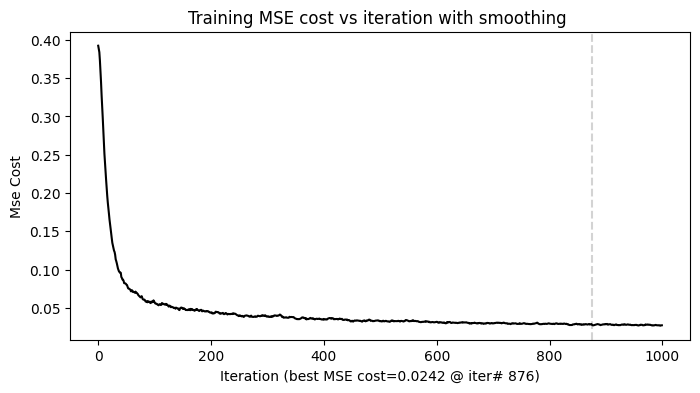

In [28]:
### Plot training cost
meas_plot(train_mse_hist, meas='MSE cost', task='min', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.8,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctrain_mse.eps")}')

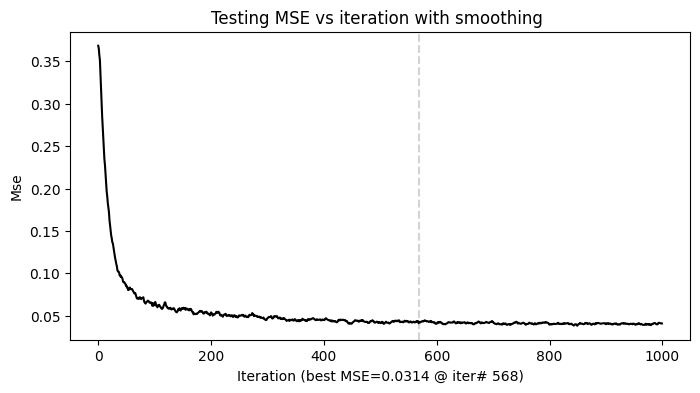

In [29]:
### Plot test cost
meas_plot(test_mse_hist, meas='MSE', task='min', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.8,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctest_mse.eps")}')

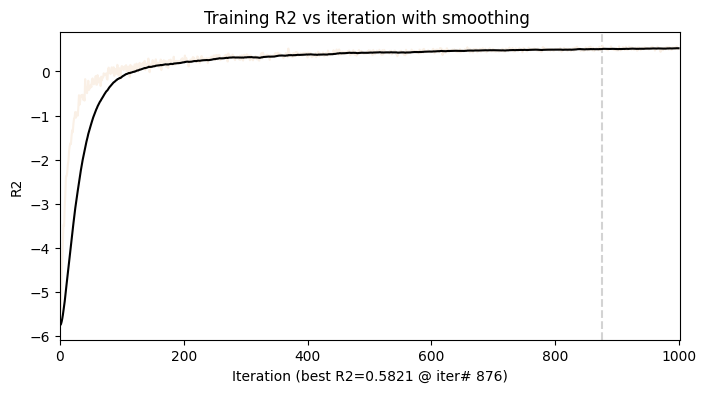

In [30]:
### Plot training accuracy
meas_plot(train_r2_hist, meas='R2', task='max', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), #ylim=(0.4, 1),
                  backplot=True, back_color='linen', smooth_weight=0.95,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctrain_r2.eps")}')

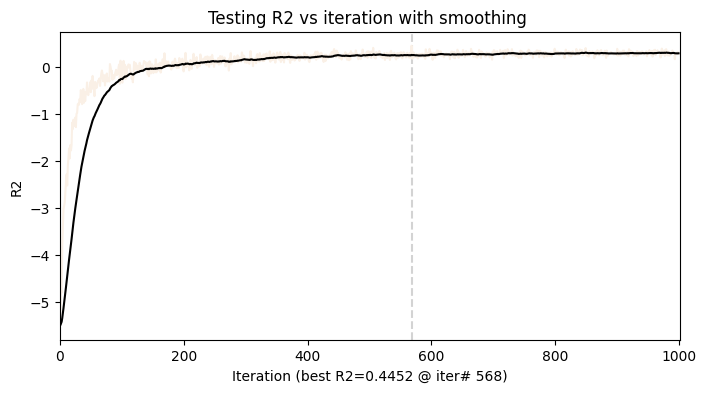

In [31]:
### Plot testing accuracy
meas_plot(test_r2_hist, meas='R2', task='max', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), #ylim=(0.35, 0.95),
                  backplot=True, back_color='linen', smooth_weight=0.95,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctest_r2.eps")}')

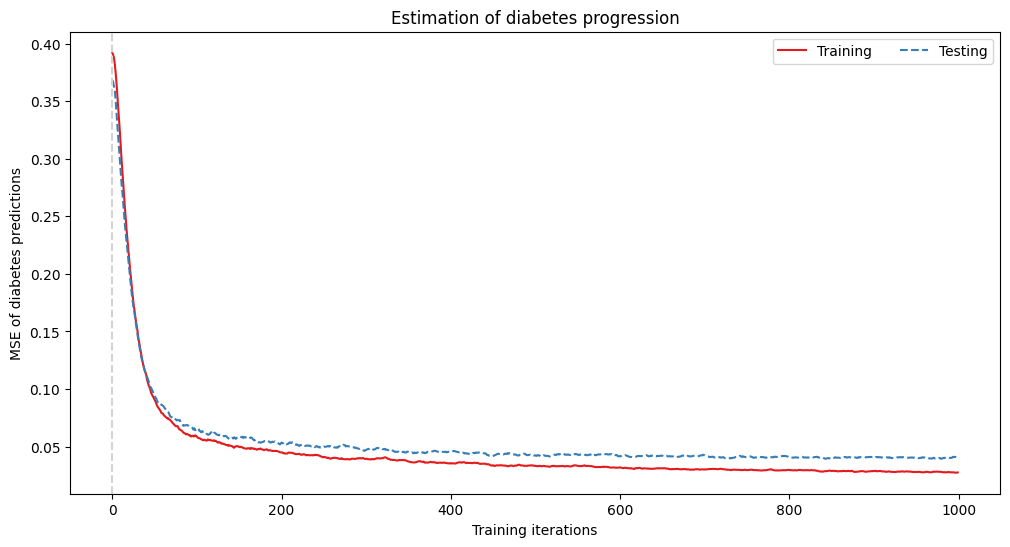

In [32]:
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=['Training', 'Testing'], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='MSE of diabetes predictions',
    legend_cols=2, smooth_weight=0.9, title='Estimation of diabetes progression',
    save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctrain_ctest_mse.eps")}')

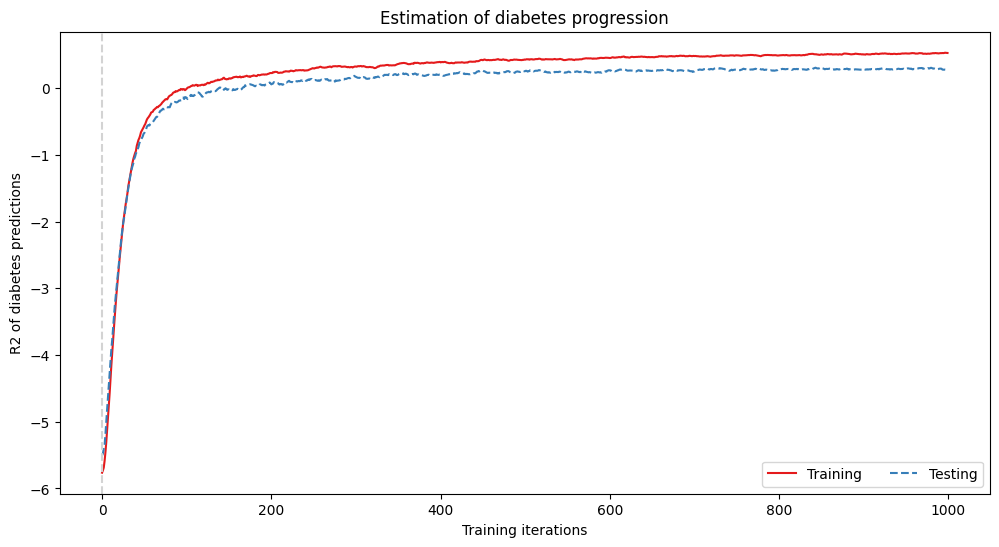

In [33]:
multi_plot_series(
    [train_r2_hist, test_r2_hist], X_list=[0, 0], labels=['Training', 'Testing'], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='R2 of diabetes predictions',
    legend_cols=2, smooth_weight=0.9, title='Estimation of diabetes progression',
    save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_ctrain_ctest_r2.eps")}')

### Save the training information for further analysis

In [34]:
### Save all training and scoring results
import pickle

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_copt_params.pkl'), 'wb') as f:
    pickle.dump(opt_params, f, pickle.HIGHEST_PROTOCOL); f.close()
    
with open(os.path.join(RSRC_STORE, RSRC_NAME+'_chist_params.pkl'), 'wb') as f:
    pickle.dump(hist_params, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_copt_point.pkl'), 'wb') as f:
    pickle.dump(opt_point, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_ctrain_mse_hist.pkl'), 'wb') as f:
    pickle.dump(train_mse_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_ctest_mse_hist.pkl'), 'wb') as f:
    pickle.dump(test_mse_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_ctrain_r2_hist.pkl'), 'wb') as f:
    pickle.dump(train_r2_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_ctest_r2_hist.pkl'), 'wb') as f:
    pickle.dump(test_r2_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

print(f'\nSaved all training and scoring results:   "{RSRC_NAME}" in store "{RSRC_STORE}"')
print(f'To read the data set back use: "df = pd.read_pickle(file_path)"')


Saved all training and scoring results:   "diabetes" in store "rsrc"
To read the data set back use: "df = pd.read_pickle(file_path)"


## What's next?
*At this point you can improve this notebook by performing the following tasks:*

- Save the history of loss and accuracy into a resource folder
- Save all model parameters kept during the model training into a resource folder
- Play with the smoothing factor in all plots to gain insight into volatility of your scores
- Analyse all accumulated data and report your observations, reflect on your learning

*As an extension:*

- Prepare an Automobile data set, a model and its scores, to predict car price (exclude symboling which is a variable dependent on price)
- Repeat the entire process for the "sonar" data set (link included above)
- Enjoy learning predictive analytics using classical and quantum ML models

## Modifications (do not remove)
Under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license, if you perform any changes to this notebook, please list them here, adding a note with your name, contact details, date and changes to the code.

- [Jacob Cybulski](http://jacobcybulski.com) (2024, 1 Oct): The author of this notebook added this section to record all code changes

## Main systems in use

In [35]:
!pip list | grep -e PennyLane -e torch

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
torch                     2.6.0+cpu
torchaudio                2.6.0+cpu
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cpu
